**Import the dependencies**

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [2]:
IMAGE_SIZE = 256 # the size of our training images 256 x 256.
BATCH_SIZE = 32 
CHANNELS = 3 # RGB
EPOCHS = 50

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training_images",
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)
type(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


list

In [5]:
batch_count  = len(dataset) # This actually gives us the number of batches.
print('The number of batches is: ', batch_count)
print('The number of batches x batch size = ', batch_count * BATCH_SIZE)

The number of batches is:  68
The number of batches x batch size =  2176


**Data Visualization**

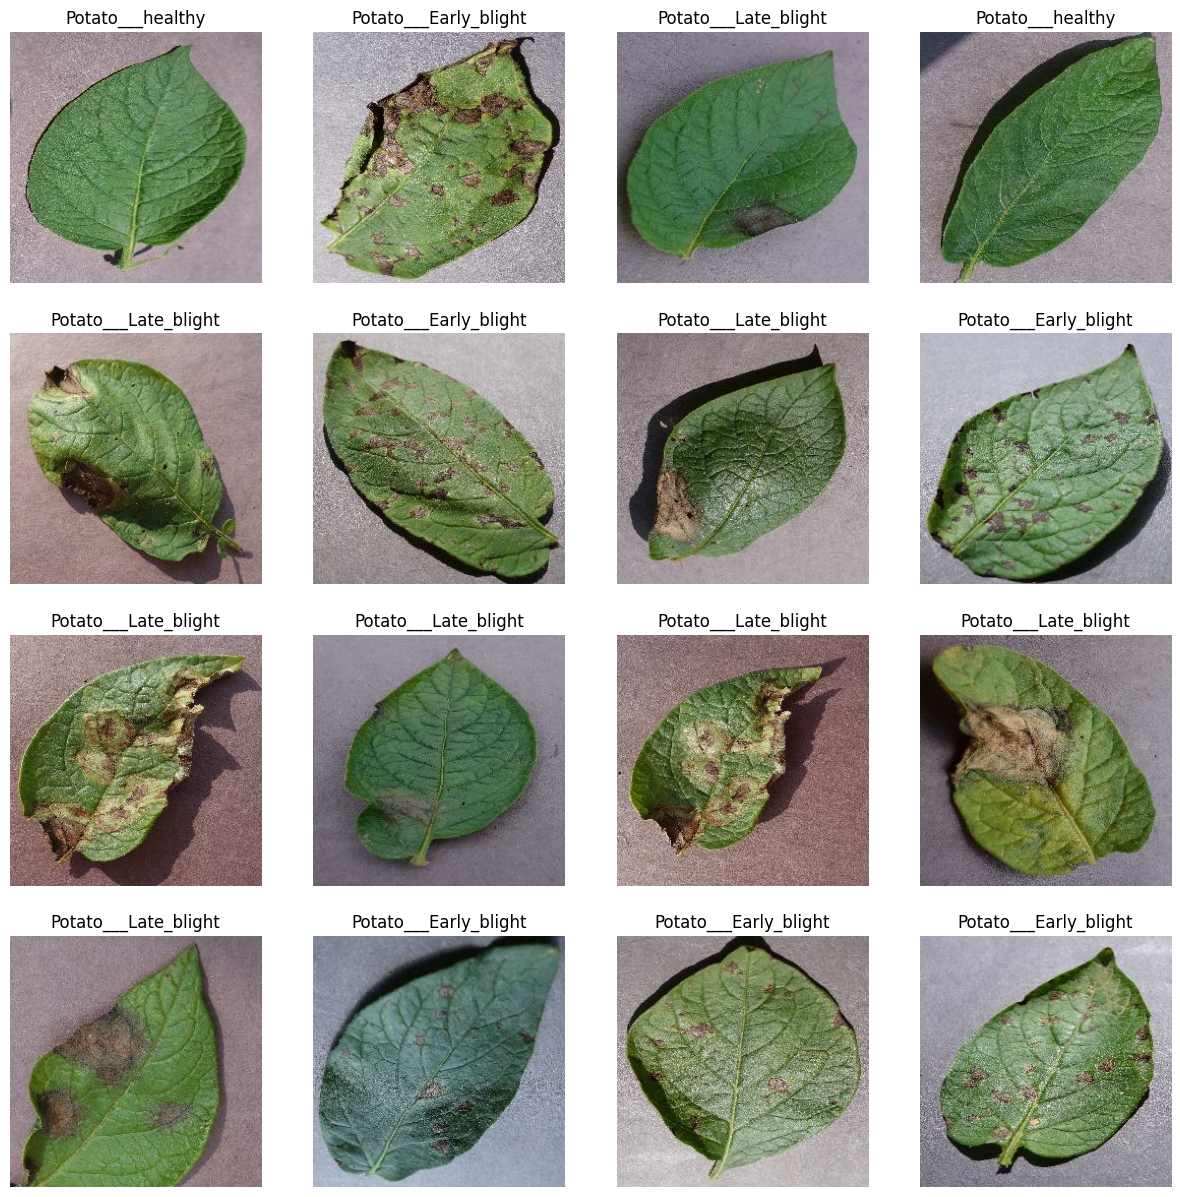

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')


**Train-Test Split**

In [7]:
def train_test_split(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

    

In [8]:
train_ds, val_ds, test_ds = train_test_split(dataset)
print('The training size: ', len(train_ds))
print('The validation size: ', len(val_ds))
print('The test size is: ', len(test_ds))

The training size:  54
The validation size:  6
The test size is:  8


Cache, Shuffle, Prefetch the dataset

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Data Preprocessing and Augmentation:**

Prior to inputting our images into the network, it is essential to resize them to the target dimensions. Additionally, for enhanced model performance, we should normalize the pixel values of the images, ensuring they fall within the range of 0 to 1 by dividing them by 256. This normalization process should be applied both during the training phase and during inference. Consequently, we can incorporate it as a layer within our Sequential Model.

Data augmentation becomes crucial when we have limited data available, as it enhances the accuracy of our model by artificially increasing the dataset through various transformations and variations.


In [10]:

data_preprocessing = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1./255),
    ]
)

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Building**

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    data_preprocessing,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

**Compiling the model**:

We use adam **Optimizer, SparseCategoricalCrossentropy** for losses and **accuracy** as a metric.

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


54/54 [==============================] - 25s 432ms/step - loss: 0.9120 - accuracy: 0.4815 - val_loss: 0.8674 - val_accuracy: 0.4427
Epoch 2/50
54/54 [==============================] - 24s 436ms/step - loss: 0.7179 - accuracy: 0.6372 - val_loss: 0.4731 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 25s 461ms/step - loss: 0.4406 - accuracy: 0.8218 - val_loss: 0.2719 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 65s 1s/step - loss: 0.3424 - accuracy: 0.8559 - val_loss: 0.1958 - val_accuracy: 0.9427
Epoch 5/50
54/54 [==============================] - 113s 2s/step - loss: 0.2818 - accuracy: 0.8935 - val_loss: 0.2806 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 94s 2s/step - loss: 0.2370 - accuracy: 0.9068 - val_loss: 0.1301 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 21s 376ms/step - loss: 0.2141 - accuracy: 0.9120 - val_loss: 0.1441 - val_accuracy: 0.9479
Epoch

In [16]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

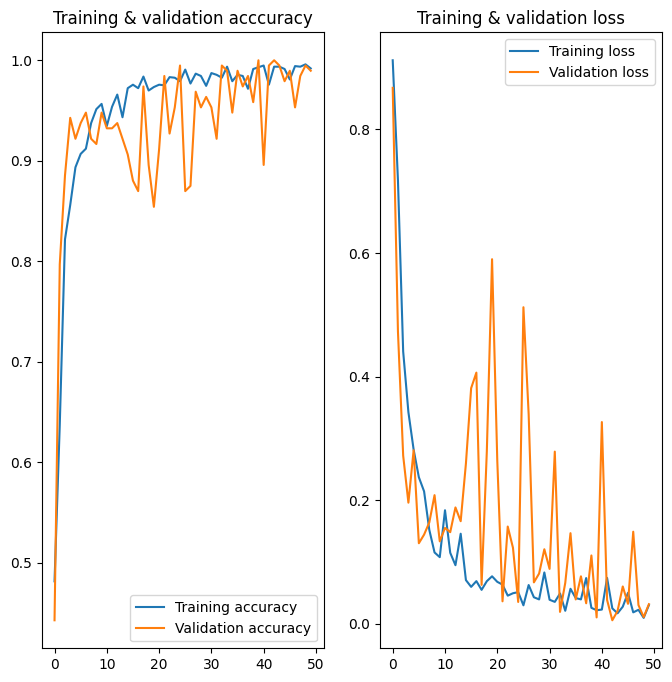

In [18]:
plt.figure(figsize = (8, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & validation acccuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training & validation loss')
plt.show()




**Inference on sample image**

Image to predict: 
Actual label:  Potato___Late_blight
1/1 [==============================] - 0s 304ms/step
Predicted label:  Potato___Late_blight


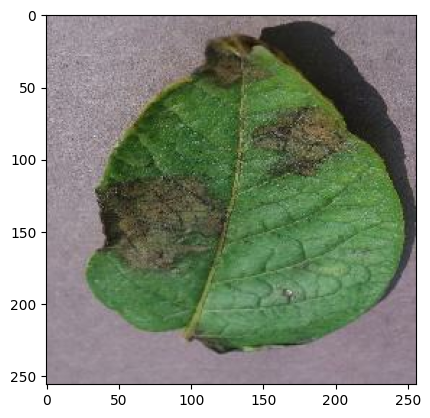

In [19]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('Image to predict: ')
    plt.imshow(first_image)
    print('Actual label: ', class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print('Predicted label: ', class_names[np.argmax(batch_prediction[0])])

**Model inference**

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 32ms/step


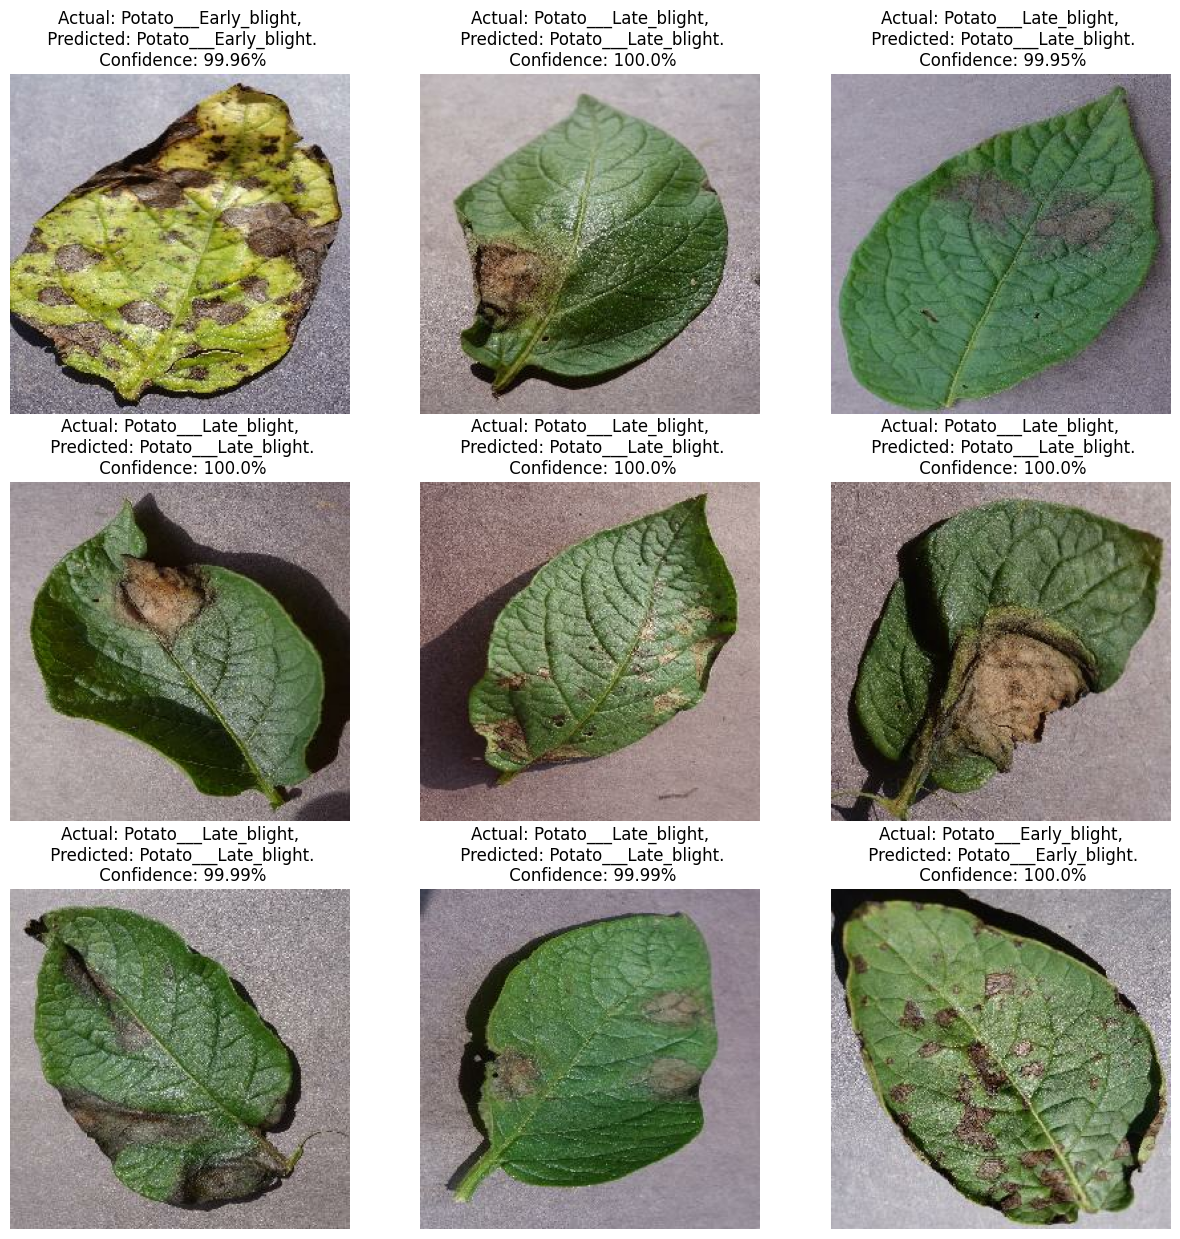

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Saving the model**

In [22]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets


In [25]:
model.save("../potatoes.h5")